We want to find a set of fucntios to let the user to align a picture with 4 gard coded coordinates

In [15]:
from skimage import io
import matplotlib.pyplot as plt
from createGrid import *
import numpy as np
import random
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from IPython.display import display,clear_output    


# set up folders
#imageDataDir = 'C:\\Users\\tequi\\Documents\\repos\\sudoku_dataset\\images\\'
imageDataDir = 'C:\\Users\\JOSA\\Documents\\imagesRepo\\sudoku_dataset\\images\\'

allImages = []
for file in os.listdir(imageDataDir):
    if file.endswith(".jpg"):
        allImages.append(file)


<IPython.core.display.Javascript object>


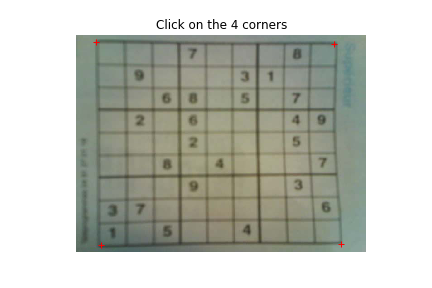

In [20]:
%matplotlib nbagg
# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 

filename = os.path.join(imageDataDir, allImages[0])
src = io.imread(filename)

f,a = plt.subplots()
a.imshow(src, cmap=plt.cm.gray)
a.set_axis_off()
a.set_title('Click on the 4 corners')
pos = []
def onclick(event):
    pos.append([int(event.ydata), int(event.xdata)]) #nned to invert to match row/col coord system
    a.plot(event.xdata,event.ydata, '+r')
f.canvas.mpl_connect('button_press_event', onclick)
f.show()

In [21]:
# the convention is to number the coords from 1 to 4 as
# 1 TL
# 2 TR
# 3 BR
# 4 BR
# Of the 4 coordinates given, we need to sort them appropriately

# We use the logic:
# 1 has the lowest row * col
# 3 has the highest row * col
# 2 has the remaining lowest row of the remaining
# 4 is the remaining point
def getIdxs(pos):
    if not len(pos) == 4:
        print('pos must have exaclty 4 sets of coordinates')
        return([])
    prodPos = []
    allRows = []
    for i in range(0,4):
        prodPos.append(pos[i][0]*pos[i][1])
        allRows.append(pos[i][0])
    
    # 1
    idx_1 = prodPos.index(np.amin(prodPos))
    # 3
    idx_3 = prodPos.index(np.amax(prodPos))
    # 2
    allRows[idx_1] = 1e10 #insane high number (we will not have a picture with more than 1e10 rows)
    idx_2 = allRows.index(np.amin(allRows))
    # 4
    allRows[idx_1] = 0 #we will not have a picture with 0 rows
    allRows[idx_3] = 0 #we will not have a picture with 0 rows
    idx_4 = allRows.index(np.amax(allRows))

    return([idx_1, idx_2, idx_3, idx_4])


In [22]:
# sort the given pos
posIdxs = getIdxs(pos)

#get grid borders
allRowsp12, allColsp12 = getCoords(pos[posIdxs[0]][0], pos[posIdxs[0]][1], pos[posIdxs[1]][0], pos[posIdxs[1]][1], 'row')    

allRowsp23, allColsp23 = getCoords(pos[posIdxs[1]][0], pos[posIdxs[1]][1], pos[posIdxs[2]][0], pos[posIdxs[2]][1], 'col')

allRowsp43, allColsp43 = getCoords(pos[posIdxs[3]][0], pos[posIdxs[3]][1], pos[posIdxs[2]][0], pos[posIdxs[2]][1], 'row')

allRowsp14, allColsp14 = getCoords(pos[posIdxs[0]][0], pos[posIdxs[0]][1], pos[posIdxs[3]][0], pos[posIdxs[3]][1], 'col')    


imgGrid = np.zeros((src.shape[0], src.shape[1]))
for i in range(0,10):
    xs, ys = getLineFullImg(allRowsp12[i], allColsp12[i], allRowsp43[i], allColsp43[i], 'col')
    imgGrid[xs, ys] = imgGrid[xs, ys] + 1
    xs, ys = getLineFullImg(allRowsp23[i], allColsp23[i], allRowsp14[i], allColsp14[i], 'row')
    imgGrid[xs, ys] = imgGrid[xs, ys] + 1
squares = np.argwhere(imgGrid==2)

#assuming this difference is representative of the average size of a square
squareSize = int(np.mean([allColsp12[1] - allColsp12[0], allRowsp14[1] - allRowsp14[0]])) 
maxCol = np.amax(allColsp23)
maxRow = np.amax(allRowsp43)
tmpGrid = np.zeros((src.shape[0], src.shape[1]))
iC = 0
for ii in range(0, 100):
    rowStart = squares[ii][0]
    colStart = squares[ii][1]
    rowEnd = rowStart + squareSize
    colEnd = colStart + squareSize
        
    if colEnd <= maxCol+5 and rowEnd <= maxRow+5:
        tmpGrid[rowStart:rowEnd, colStart:colEnd] = 255

tmpGrid[imgGrid > 0] =0
print('Done')



Done


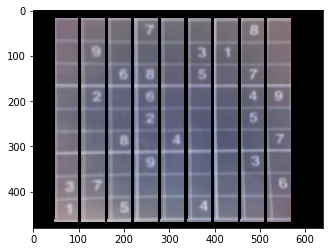

In [23]:
%matplotlib inline
imgC = src.copy()
imgC[:,:,0] = imgC[:,:,0]*tmpGrid
imgC[:,:,1] = imgC[:,:,1]*tmpGrid
imgC[:,:,2] = imgC[:,:,2]*tmpGrid
plt.imshow(imgC, cmap=plt.cm.gray)
plt.show()

Now I try to put everything together. Ideally I want the image were I click the 4 corners to display the grid once the 4 corners are done.

First I convert the steps above into a function

In [24]:
def getImageGrid(pos, imgShape):
    if not len(pos) == 4:
        return(np.zeros(1,1)) #return a small array. We will then check that its shape in the main UI logic
    
    # sort the given pos
    posIdxs = getIdxs(pos)

    #get grid borders
    allRowsp12, allColsp12 = getCoords(pos[posIdxs[0]][0], pos[posIdxs[0]][1], pos[posIdxs[1]][0], pos[posIdxs[1]][1], 'row')    

    allRowsp23, allColsp23 = getCoords(pos[posIdxs[1]][0], pos[posIdxs[1]][1], pos[posIdxs[2]][0], pos[posIdxs[2]][1], 'col')

    allRowsp43, allColsp43 = getCoords(pos[posIdxs[3]][0], pos[posIdxs[3]][1], pos[posIdxs[2]][0], pos[posIdxs[2]][1], 'row')

    allRowsp14, allColsp14 = getCoords(pos[posIdxs[0]][0], pos[posIdxs[0]][1], pos[posIdxs[3]][0], pos[posIdxs[3]][1], 'col')    


    imgGrid = np.zeros((imgShape[0], imgShape[1]))
    for i in range(0,10):
        xs, ys = getLineFullImg(allRowsp12[i], allColsp12[i], allRowsp43[i], allColsp43[i], 'col')
        imgGrid[xs, ys] = imgGrid[xs, ys] + 1
        xs, ys = getLineFullImg(allRowsp23[i], allColsp23[i], allRowsp14[i], allColsp14[i], 'row')
        imgGrid[xs, ys] = imgGrid[xs, ys] + 1
    squares = np.argwhere(imgGrid==2)

    #assuming this difference is representative of the average size of a square
    squareSize = int(np.mean([allColsp12[1] - allColsp12[0], allRowsp14[1] - allRowsp14[0]])) 
    maxCol = np.amax(allColsp23)
    maxRow = np.amax(allRowsp43)
    tmpGrid = np.zeros((imgShape[0], imgShape[1]))
    for ii in range(0, 100):
        rowStart = squares[ii][0]
        colStart = squares[ii][1]
        rowEnd = rowStart + squareSize
        colEnd = colStart + squareSize
        
        if colEnd <= maxCol+5 and rowEnd <= maxRow+5:
            tmpGrid[rowStart:rowEnd, colStart:colEnd] = 255
            
    tmpGrid[imgGrid > 0] = 0
    
    return(tmpGrid)

def getOverlay(img, background):
    background[:,:,0] = background[:,:,0]*img
    background[:,:,1] = background[:,:,1]*img
    background[:,:,2] = background[:,:,2]*img
    return(background)


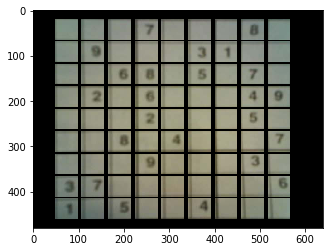

In [25]:
# test it

from skimage.morphology import binary_erosion
%matplotlib inline
gridIs = getImageGrid(pos, src.shape)
gridIs = binary_erosion(gridIs)

overlayed = getOverlay(gridIs, src)

plt.imshow(overlayed, cmap=plt.cm.gray)
plt.show()

<IPython.core.display.Javascript object>


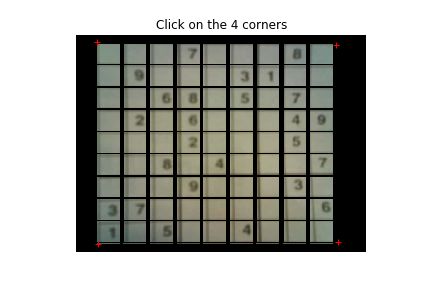

In [32]:
%matplotlib nbagg
# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 

filename = os.path.join(imageDataDir, allImages[0])
src = io.imread(filename)

f,a = plt.subplots()
a.imshow(src, cmap=plt.cm.gray)
a.set_axis_off()
a.set_title('Click on the 4 corners')
def onclick(event):
    pos.append([int(event.ydata), int(event.xdata)]) #nned to invert to match row/col coord system
    a.plot(event.xdata,event.ydata, '+r')
    if len(pos) == 4:
        gridIs = getImageGrid(pos, src.shape)
        gridIs = binary_erosion(gridIs)
        overlayed = getOverlay(gridIs, src)
        a.imshow(overlayed, cmap=plt.cm.gray)

    
f.canvas.mpl_connect('button_press_event', onclick)
f.show()

